In [ ]:
! pip install ijson

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
!unzip 'trainA_original_700.zip' # initial image tensors without resize

Archive:  trainA_original_700.zip
replace trainA_original_700/trainA_original_700/0000f77c-6257be58.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# -----------------------
# Global settings & helpers
# -----------------------

# Input image size (height, width)
ISIZE = (720, 1280)

# ImageNet statistics (for VGG16)
# imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
# imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def normalize_tensor(img):
    """Normalize a tensor image (C, H, W) with values in [0,255]."""
    img = img / 255.0
    return img

def unnormalize_tensor(img):
    """Convert a normalized tensor back to a displayable numpy image."""
    img = img * 255.0
    return img.clamp(0, 255).byte().cpu().numpy()

# Global anchor parameters
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]


In [ ]:
import ijson


def extract_first_n_labels(json_file_path, n):
    labels = []
    with open(json_file_path, 'rb') as f:
        parser = ijson.items(f, 'item')
        for i, item in enumerate(parser):
            if i >= n:
                break
            filtered_labels = [
                {"category": li.get("category"), "box2d": li.get("box2d")}
                for li in item.get("labels", []) if "box2d" in li
            ]
            labels.append({
                "name": item.get("name"),
                "timestamp": item.get("timestamp"),
                "labels": filtered_labels
            })
    return labels

def standardize_filename(path_or_name):
    base = os.path.basename(path_or_name)
    base, _ = os.path.splitext(base)
    return base

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, labels, pt_dir='pt_files'):
        self.image_dir = image_dir
        self.pt_dir = pt_dir
        os.makedirs(self.pt_dir, exist_ok=True)
        self.image_files = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        self.label_dict = {}
        for item in labels:
            key = standardize_filename(item["name"])
            self.label_dict[key] = item

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        pt_path = os.path.join(
            self.pt_dir,
            os.path.basename(image_path)
            .replace('.jpg', '.pt')
            .replace('.png', '.pt')
            .replace('.jpeg', '.pt')
        )
        if os.path.exists(pt_path):
            image_tensor = torch.load(pt_path)
        else:
            image = Image.open(image_path).convert('RGB')
            if image.size != (ISIZE[1], ISIZE[0]):  # PIL: (width, height)
                image = image.resize((ISIZE[1], ISIZE[0]))
            image_tensor = transforms.PILToTensor()(image).float()
            torch.save(image_tensor, pt_path)
        image_tensor = normalize_tensor(image_tensor)

        base_key = standardize_filename(image_path)
        matched = self.label_dict.get(base_key, None)
        if matched is None or "labels" not in matched:
            target = {"boxes": torch.zeros((0, 4), dtype=torch.float32),
                      "labels": torch.zeros((0,), dtype=torch.int64),
                      "names": [],
                      "index": idx}
        else:
            boxes = []
            cats = []
            for obj in matched["labels"]:
                if "box2d" in obj:
                    b2d = obj["box2d"]
                    boxes.append([float(b2d["y1"]), float(b2d["x1"]),
                                  float(b2d["y2"]), float(b2d["x2"])])
                    cats.append(obj["category"])
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,4), dtype=torch.float32)
            labels_tensor = torch.tensor([1] * len(cats), dtype=torch.int64)
            target = {"boxes": boxes_tensor, "labels": labels_tensor, "names": cats, "index": idx}
        return {"image": image_tensor, "boxes": target["boxes"], "labels": target["labels"],
                "names": target["names"], "index": target["index"]}

# Custom collate function (your version)
def custom_collate_fn(batch):
    images = [item["image"] for item in batch]
    boxes = [item["boxes"] for item in batch]
    labels = [item["labels"] for item in batch]
    names = [item["names"] for item in batch]
    indices = [item["index"] for item in batch]
    return {"images": torch.stack(images, 0),
            "boxes": boxes,
            "labels": labels,
            "names": names,
            "indices": indices}

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

def show_corner_bbs(im, bbs):
    # im expected to be (C, H, W) tensor; convert to numpy image for plotting
    im_np = unnormalize_tensor(im)
    plt.imshow(np.transpose(im_np, (1, 2, 0)))
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))
    plt.show()

def create_ground_truth_rect(bb, color='blue'):
    # Now handles [y1,x1,y2,x2] format
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]),  # (x1,y1)
                        bb[3]-bb[1],     # width (x2-x1)
                        bb[2]-bb[0],     # height (y2-y1)
                        color=color, fill=False, lw=3)

def show_ground_truth_bbs(im, bbs):
    im_np = unnormalize_tensor(im)
    plt.imshow(np.transpose(im_np, (1, 2, 0)))

    for bb in bbs:
        plt.gca().add_patch(create_ground_truth_rect(bb))

    plt.show()

# -----------------------
# Vectorized IoU Computation
# -----------------------

def compute_iou_matrix(pred_boxes, gt_boxes):
    """
    Compute IoU between predicted boxes (N,4) and ground truth boxes (M,4).
    Handles edge cases where arrays might be empty.

    Args:
        pred_boxes: np.array of shape (N,4) [y1,x1,y2,x2]
        gt_boxes: np.array of shape (M,4) [y1,x1,y2,x2]

    Returns:
        IoU matrix of shape (N,M)
    """
    # Handle empty inputs
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return np.zeros((len(pred_boxes), len(gt_boxes)))

    # Ensure arrays are numpy and float32
    pred_boxes = np.asarray(pred_boxes, dtype=np.float32)
    gt_boxes = np.asarray(gt_boxes, dtype=np.float32)

    # Compute intersection areas
    inter_ymin = np.maximum(pred_boxes[:, None, 0], gt_boxes[:, 0])
    inter_xmin = np.maximum(pred_boxes[:, None, 1], gt_boxes[:, 1])
    inter_ymax = np.minimum(pred_boxes[:, None, 2], gt_boxes[:, 2])
    inter_xmax = np.minimum(pred_boxes[:, None, 3], gt_boxes[:, 3])

    inter_h = np.maximum(inter_ymax - inter_ymin, 0.)
    inter_w = np.maximum(inter_xmax - inter_xmin, 0.)
    inter_area = inter_h * inter_w

    # Compute union areas
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])

    union_area = pred_area[:, None] + gt_area - inter_area

    # Compute IoU
    iou_matrix = inter_area / (union_area + 1e-8)  # Add epsilon to avoid division by zero

    return iou_matrix

def compute_iou_loss(anchors, gt_boxes):
    """
    Compute IoU loss for matched bounding boxes with list inputs.

    Parameters:
        pred_boxes_list: List of lists [[y1,x1,y2,x2], ...] (N boxes)
        gt_boxes_list: List of lists [[y1,x1,y2,x2], ...] (M boxes)

    Returns:
        IoU Loss (float): 1 - mean IoU of matched boxes
    """
    anchors = anchors.astype(np.float32)
    gt_boxes = gt_boxes.astype(np.float32)
    # Compute IoU matrix
    iou_matrix = compute_iou_matrix(anchors, gt_boxes)

    # Find best matches (each ground truth gets its best matching prediction)
    best_iou_for_each_gt = np.max(iou_matrix, axis=0)

    # Calculate mean IoU of the best matches
    mean_iou = np.mean(best_iou_for_each_gt) if len(best_iou_for_each_gt) > 0 else 0

    # Compute IoU loss
    iou_loss = 1 - mean_iou

    return iou_loss

def compute_iou_vectorized(anchors, gt_boxes):
    """
    Compute IoU between anchors (N,4) and gt_boxes (M,4).
    Boxes in [y1,x1,y2,x2] format.
    Returns IoU matrix of shape (N, M).
    """
    anchors = anchors.astype(np.float32)
    gt_boxes = gt_boxes.astype(np.float32)
    inter_y1 = np.maximum(anchors[:, None, 0], gt_boxes[None, :, 0])
    inter_x1 = np.maximum(anchors[:, None, 1], gt_boxes[None, :, 1])
    inter_y2 = np.minimum(anchors[:, None, 2], gt_boxes[None, :, 2])
    inter_x2 = np.minimum(anchors[:, None, 3], gt_boxes[None, :, 3])
    inter_h = np.maximum(inter_y2 - inter_y1, 0)
    inter_w = np.maximum(inter_x2 - inter_x1, 0)
    inter_area = inter_h * inter_w
    anchor_area = (anchors[:,2]-anchors[:,0])*(anchors[:,3]-anchors[:,1])
    gt_area = (gt_boxes[:,2]-gt_boxes[:,0])*(gt_boxes[:,3]-gt_boxes[:,1])
    union = anchor_area[:,None] + gt_area[None,:] - inter_area
    iou = inter_area / union
    return iou

# -----------------------
# Revised bbox_generation Function (Vectorized and Padded)
# -----------------------

def bbox_generation(images, targets, X_FM, Y_FM):
    """
    Compute regression targets and classification labels for all anchors.
    All anchors (generated over the full feature map) receive a target;
    anchors outside the image are ignored (label = -1).
    Returns:
       anchor_locations_all_merge: (B, total_anchors, 4)
       anchor_labels_all_merge: (B, total_anchors)
       anchors: (total_anchors, 4)
    """
    num_batch = len(images)
    C, H_IMG, W_IMG = images[0].shape

    # Generate full grid anchors over feature map
    total_positions = X_FM * Y_FM
    num_anchor_per_pos = len(ratios) * len(anchor_scales)
    total_anchors = total_positions * num_anchor_per_pos

    # Generate grid centers (using strides)
    sub_sampling_x = float(W_IMG) / X_FM
    sub_sampling_y = float(H_IMG) / Y_FM

    shift_x = np.arange(sub_sampling_x, (X_FM+1)*sub_sampling_x, sub_sampling_x)
    shift_y = np.arange(sub_sampling_y, (Y_FM+1)*sub_sampling_y, sub_sampling_y)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)  # shape (Y_FM, X_FM)
    centers = np.stack([shift_y.ravel() - sub_sampling_y/2, shift_x.ravel() - sub_sampling_x/2], axis=1)  # (total_positions, 2)

    # For each center, generate anchors
    anchors = []
    for center in centers:
        cy, cx = center
        for ratio in ratios:
            for scale in anchor_scales:
                h = sub_sampling_y * scale * np.sqrt(ratio)
                w = sub_sampling_x * scale * np.sqrt(1.0/ratio)
                y1 = cy - h/2.
                x1 = cx - w/2.
                y2 = cy + h/2.
                x2 = cx + w/2.
                anchors.append([y1, x1, y2, x2])
    anchors = np.array(anchors, dtype=np.float32)  # shape (total_anchors, 4)

    # Create ground-truth arrays for all anchors (padded to total_anchors)
    # Initialize labels to -1 (ignore) and loc targets to zeros.
    anchor_labels_all = []
    anchor_locs_all = []
    pos_iou_threshold = 0.7
    neg_iou_threshold = 0.3
    n_sample = 256
    pos_ratio = 0.5

    # Compute valid indices: those anchors that are completely inside the image.
    valid_idx = np.where((anchors[:,0] >= 0) & (anchors[:,1] >= 0) &
                         (anchors[:,2] <= H_IMG) & (anchors[:,3] <= W_IMG))[0]

    for i in range(num_batch):
        # Create full target arrays for this image.
        labels = -1 * np.ones((anchors.shape[0],), dtype=np.int32)
        locs = np.zeros((anchors.shape[0], 4), dtype=np.float32)
        gt_boxes_tensor = targets[i]["boxes"]
        if gt_boxes_tensor.numel() > 0:
            gt_boxes = gt_boxes_tensor.cpu().numpy()  # shape (M,4)
            # Compute IoU for valid anchors only.
            valid_anchors = anchors[valid_idx]
            ious = compute_iou_vectorized(valid_anchors, gt_boxes)  # (N_valid, M)
            max_ious = np.max(ious, axis=1)if ious.size else np.array([])
            argmax_ious = np.argmax(ious, axis=1)
            # Set targets for valid anchors.
            valid_labels = -1 * np.ones((valid_anchors.shape[0],), dtype=np.int32)
            valid_labels[max_ious >= pos_iou_threshold] = 1
            valid_labels[max_ious < neg_iou_threshold] = 0
            # Ensure every GT box gets at least one positive anchor.
            gt_max_ious = np.max(ious, axis=0)  # (M,)
            for j in range(gt_boxes.shape[0]):
                inds = np.where(ious[:, j] == gt_max_ious[j])[0]
                valid_labels[inds] = 1

            # Subsample positives and negatives in valid region.
            pos_inds = np.where(valid_labels == 1)[0]
            neg_inds = np.where(valid_labels == 0)[0]
            if len(pos_inds) > int(pos_ratio * n_sample):
                disable = np.random.choice(pos_inds, size=(len(pos_inds) - int(pos_ratio * n_sample)), replace=False)
                valid_labels[disable] = -1
            remaining = n_sample - np.sum(valid_labels == 1)
            if len(neg_inds) > remaining:
                disable = np.random.choice(neg_inds, size=(len(neg_inds) - remaining), replace=False)
                valid_labels[disable] = -1

            # Compute regression targets for positive valid anchors.
            valid_locs = np.zeros((valid_anchors.shape[0], 4), dtype=np.float32)
            pos_valid_inds = np.where(valid_labels == 1)[0]
            if len(pos_valid_inds) > 0:
                pos_anchors = valid_anchors[pos_valid_inds]
                anchor_heights = pos_anchors[:,2] - pos_anchors[:,0]
                anchor_widths = pos_anchors[:,3] - pos_anchors[:,1]
                anchor_ctr_y = pos_anchors[:,0] + 0.5 * anchor_heights
                anchor_ctr_x = pos_anchors[:,1] + 0.5 * anchor_widths

                target_gt = gt_boxes[argmax_ious[pos_valid_inds]]
                gt_heights = target_gt[:,2] - target_gt[:,0]
                gt_widths = target_gt[:,3] - target_gt[:,1]
                gt_ctr_y = target_gt[:,0] + 0.5 * gt_heights
                gt_ctr_x = target_gt[:,1] + 0.5 * gt_widths

                dy = (gt_ctr_y - anchor_ctr_y) / anchor_heights
                dx = (gt_ctr_x - anchor_ctr_x) / anchor_widths
                dh = np.log(gt_heights / anchor_heights)
                dw = np.log(gt_widths / anchor_widths)
                valid_locs[pos_valid_inds, :] = np.stack([dy, dx, dh, dw], axis=1)
            # Assign computed valid targets into the full arrays.
            labels[valid_idx] = valid_labels
            locs[valid_idx, :] = valid_locs
        # Append for current image.
        anchor_labels_all.append(labels)
        anchor_locs_all.append(locs)
    anchor_labels_all_merge = np.stack(anchor_labels_all, axis=0)  # (B, total_anchors)
    anchor_locs_all_merge = np.stack(anchor_locs_all, axis=0)        # (B, total_anchors, 4)
    return anchor_locs_all_merge, anchor_labels_all_merge, anchors


In [ ]:
### Alternative way for IOU calculation

# define the iou calculation function
def compute_iou(box1, box2):
    """Compute IoU between two bounding boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

# define the function that finds the best match from predicted bounding boxes for each ground truth box
def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    """Match predicted boxes to ground truth boxes based on IoU."""
    matched_preds = {}
    gt_matched = set()
    pred_boxes = pred_boxes.astype(np.float32)
    gt_boxes = gt_boxes.astype(np.float32)

    for i, pred in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        for j, gt in enumerate(gt_boxes):
            if j in gt_matched:
                continue  # Skip matched gt boxes
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        if best_iou >= iou_threshold:
            matched_preds[i] = best_gt_idx
            gt_matched.add(best_gt_idx)

    return matched_preds # return a dictionary of predicted bounding boxes that each matches to one ground truth box
               # with format: {i}: box, where i is the order of corresponding ground truth box

# can directly use this function in the training code to get the iou loss for parameter updates
# this function calls match_prediction_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5) and compute_iou(box1, box2)
# ****** if want to change IOU threshold, change it in the input to match_prediction_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5)

'''def compute_iou_loss_vectorized(pred_boxes, gt_boxes):
    """
    Compute IoU loss for matched bounding boxes with vectorized inputs.

    Parameters:
        pred_boxes (N,4): Predicted bounding boxes [y1, x1, y2, x2]
        gt_boxes (M,4): Ground truth bounding boxes [y1, x1, y2, x2]

    Returns:
        IoU Loss (float): 1 - mean IoU of matched boxes
    """
    # Compute IoU matrix between all predictions and ground truth boxes
    iou_matrix = compute_iou_vectorized(pred_boxes, gt_boxes)

    # Find best matches - each gt box gets its best matching prediction
    # First, find for each gt box, the prediction with highest IoU
    best_pred_for_gt = np.argmax(iou_matrix, axis=0)
    best_iou_for_gt = np.max(iou_matrix, axis=0)

    # Get unique predictions that were matched to any gt box
    matched_pred_indices = np.unique(best_pred_for_gt)

    if len(matched_pred_indices) == 0:  # If no matches, return max loss (1)
        return 1.0

    # For each matched prediction, get its best IoU with any gt box
    matched_iou_values = []
    for pred_idx in matched_pred_indices:
        # Get the best IoU this prediction has with any gt box
        best_iou = np.max(iou_matrix[pred_idx])
        matched_iou_values.append(best_iou)

    mean_iou = np.mean(matched_iou_values) if matched_iou_values else 0
    iou_loss = 1 - mean_iou

    return iou_loss
'''
  # compute true positive, false positive, and false negative if we need for precision and recall calculation
def compute_tp_fp_fn(matched_preds, num_pred, num_gt): # num_pred is total number of predictions.
                                # num_gt is total number of ground boxes.
    """Calculate TP, FP, FN from matched predictions."""
    TP = len(matched_preds)
    FP = num_pred - TP
    FN = num_gt - TP
    return TP, FP, FN


In [ ]:
vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
vgg_model.eval()
for param in vgg_model.features.parameters():
    param.requires_grad = False
req_features = [layer for layer in list(vgg_model.features)[:30]]

class RPN(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor*4, kernel_size=1, stride=1)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor*2, kernel_size=1, stride=1)
        nn.init.normal_(self.conv1.weight, std=0.01)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.normal_(self.reg_layer.weight, std=0.01)
        nn.init.constant_(self.reg_layer.bias, 0)
        nn.init.normal_(self.cls_layer.weight, std=0.01)
        nn.init.constant_(self.cls_layer.bias, 0)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous().view(batch_size, -1, 2)
        objectness_score = pred_cls_scores[:,:,1]
        return pred_anchor_locs, pred_cls_scores, objectness_score

rpn_model = RPN().to(device)
optimizer = torch.optim.Adam(rpn_model.parameters(), lr=0.0015)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def pred_bbox_to_xywh(bbox, anchors):
    anchors = anchors.astype(np.float32)
    anc_height = anchors[:,2] - anchors[:,0]
    anc_width  = anchors[:,3] - anchors[:,1]
    anc_ctr_y = anchors[:,0] + 0.5 * anc_height
    anc_ctr_x = anchors[:,1] + 0.5 * anc_width
    bbox_np = bbox.detach().cpu().numpy()
    dy = bbox_np[:,0]
    dx = bbox_np[:,1]
    dh = bbox_np[:,2]
    dw = bbox_np[:,3]
    ctr_y = dy * anc_height + anc_ctr_y
    ctr_x = dx * anc_width + anc_ctr_x
    h = np.exp(dh) * anc_height
    w = np.exp(dw) * anc_width
    roi = np.zeros(bbox_np.shape, dtype=np.float32)
    roi[:,0] = ctr_x - 0.5 * w
    roi[:,1] = ctr_y - 0.5 * h
    roi[:,2] = ctr_x + 0.5 * w
    roi[:,3] = ctr_y + 0.5 * h
    return roi

def train_epochs(req_features, rpn_model, optimizer, train_dl, epochs=20, rpn_lambda=10, device = None):
    if device is None:  # If device is not specified, use the default device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rpn_model.train()
    for epoch in range(epochs):
        print("Hi")
    rpn_model.train()
    for epoch in range(epochs):
        print("Hi")
        total_samples = 0
        sum_loss = 0.0
        sum_loss_cls = 0.0
        sum_loss_loc = 0.0
        for batch in train_dl:
            images = batch["images"].to(device) # shape (B,C,H,W)
            targets = [{"boxes": b, "labels": l} for b, l in zip(batch["boxes"], batch["labels"])]
            B = images.shape[0]
            #print(f"image size: {B}")
            total_samples += B
            # Forward through frozen backbone
            imgs = images.clone()
            with torch.no_grad():
                feat = imgs
                for m in req_features:
                    feat = m(feat)
            X_FM, Y_FM = feat.shape[2], feat.shape[3]
            # Compute GT targets (for all anchors)
            gt_locs_np, gt_scores_np, anchors = bbox_generation([img for img in images], targets, X_FM, Y_FM)
            print("Hmm")
            gt_locs = torch.from_numpy(gt_locs_np.astype(np.float32)).to(device)
            gt_scores = torch.from_numpy(gt_scores_np.astype(np.float32)).to(device)
            # Forward RPN
            pred_locs, pred_scores, objectness_score = rpn_model(feat)
            # Compute classification loss: flatten predictions and GT.
            cls_loss = F.cross_entropy(pred_scores.view(-1,2),
                                       gt_scores.view(-1).long(),
                                       ignore_index=-1)
            # Compute regression loss for positive anchors only.
            pos_mask = gt_scores > 0
            if pos_mask.sum() > 0:
                pred_pos = pred_locs[pos_mask]
                gt_pos = gt_locs[pos_mask]
                diff = torch.abs(gt_pos - pred_pos)
                loc_loss = torch.where(diff < 1, 0.5 * diff**2, diff - 0.5)
                loc_loss = loc_loss.sum() / pos_mask.sum().float()
            else:
                loc_loss = torch.tensor(0.0, device=device)
            loss = cls_loss + rpn_lambda * loc_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            sum_loss_cls += cls_loss.item()
            sum_loss_loc += (rpn_lambda * loc_loss).item()
        print(f"Epoch {epoch+1}/{epochs}: Loss {sum_loss/total_samples:.3f} | Cls {sum_loss_cls/total_samples:.3f} | Loc {sum_loss_loc/total_samples:.3f}")
        if (epoch+1)%5==0:
            torch.save(rpn_model.state_dict(), f"./rpn_epoch_{epoch+1}.pth")
    return rpn_model

def validate(rpn_model, data_loader, n_images=7, top_k=20):
    rpn_model.eval()
    with torch.no_grad():
        batch = next(iter(data_loader))
        images = batch["images"][:n_images].to(device)
        targets = [{"boxes": b, "labels": l} for b, l in zip(batch["boxes"], batch["labels"])][:n_images]

        # Forward pass
        imgs = images.clone()
        for m in req_features:
            imgs = m(imgs)
        X_FM, Y_FM = imgs.shape[2], imgs.shape[3]
        _, _, anchors = bbox_generation([img for img in images], targets, X_FM, Y_FM)
        pred_locs, pred_scores, objectness_score = rpn_model(imgs)

        for i in range(min(n_images, images.shape[0])):
            rois = pred_bbox_to_xywh(pred_locs[i], anchors)

            if top_k is not None:
                # Safe handling of top_k
                k = min(top_k, objectness_score[i].shape[0])
                top_k_idx = torch.topk(objectness_score[i], k=k).indices
                boxes_to_show = rois[top_k_idx.cpu().numpy()]
                print(f"Showing {k} proposals (requested top {top_k})")
            else:
                boxes_to_show = rois

            show_corner_bbs(images[i], boxes_to_show)

            gt_boxes = targets[i]["boxes"].cpu().numpy()
            if len(gt_boxes) > 0:
                show_ground_truth_bbs(images[i], gt_boxes)

    rpn_model.train()


In [ ]:
image_dir = '/content/trainA_original_700/trainA_original_700'
pt_dir = 'trainA_testing'
json_file_path = '/content/bdd100k_labels_images_train.json'

# Extract labels from JSON (adjust number as desired)
all_labels = extract_first_n_labels(json_file_path, 20000)

# Create the custom dataset using your method
dataset = CustomDataset(image_dir, all_labels, pt_dir)

# Split using random_split (70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Create DataLoaders using your custom collate function
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=2)

Training dataset size: 489
Validation dataset size: 105
Testing dataset size: 106


In [ ]:
small_train_dataset = torch.utils.data.Subset(train_dataset, list(range(200)))
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=custom_collate_fn, num_workers=2)

Hi
Hi
Hi
Hi
Hi
Hi
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Epoch 1/5: Loss 1.171 | Cls 0.062 | Loc 1.109
Hi
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Epoch 2/5: Loss 0.944 | Cls 0.053 | Loc 0.891
Hi
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Epoch 3/5: Loss 0.903 | Cls 0.051 | Loc 0.852
Hi
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Epoch 4/5: Loss 0.871 | Cls 0.050 | Loc 0.821
Hi
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Hmm
Epoch 5/5: Loss 0.891 | Cls 0.051 | Loc 0.839
Validation on training data:
Showing 20 proposals (requested top 20)


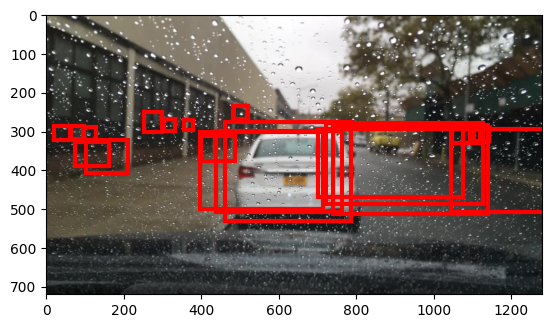

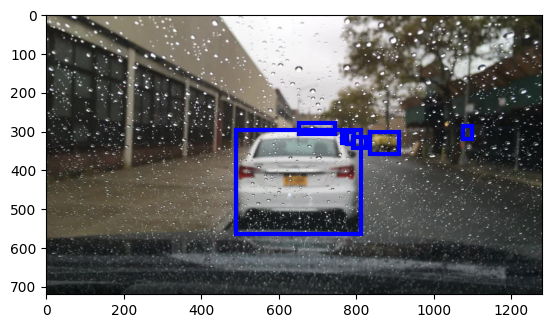

Showing 20 proposals (requested top 20)


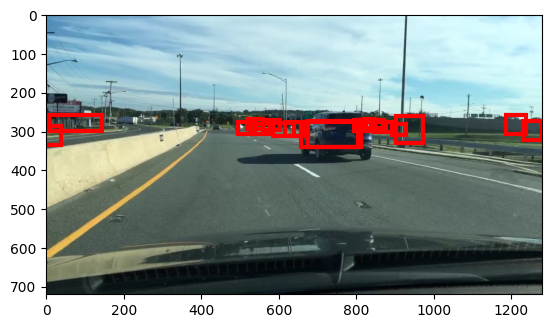

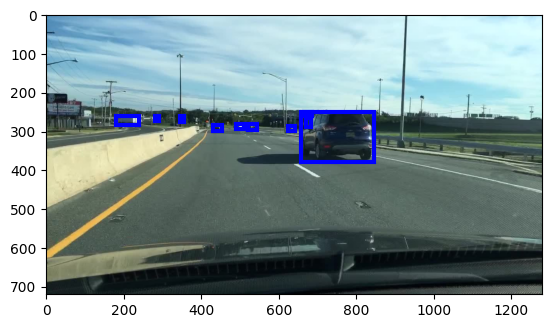

Showing 20 proposals (requested top 20)


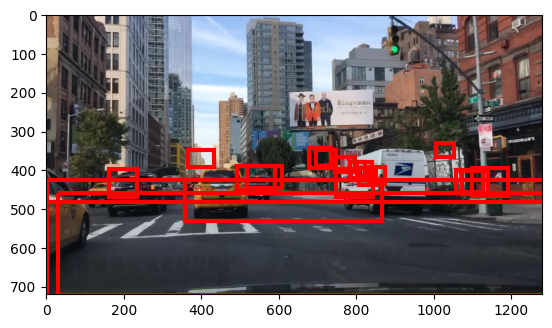

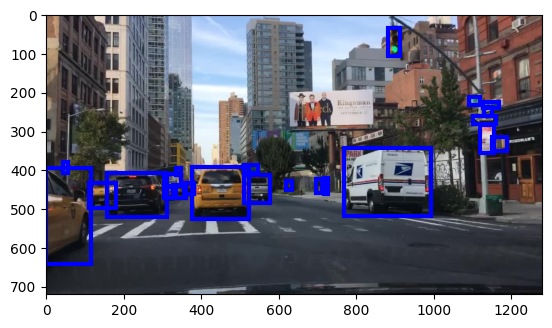

Showing 20 proposals (requested top 20)


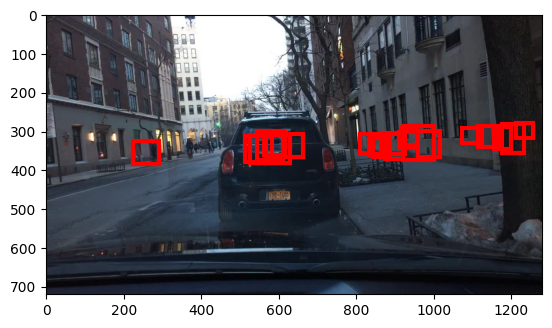

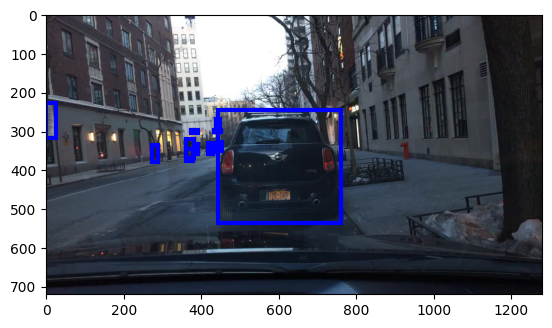

Showing 20 proposals (requested top 20)


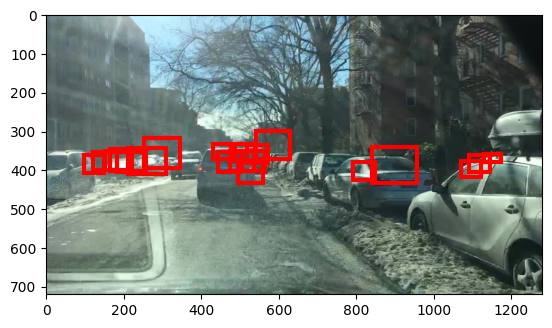

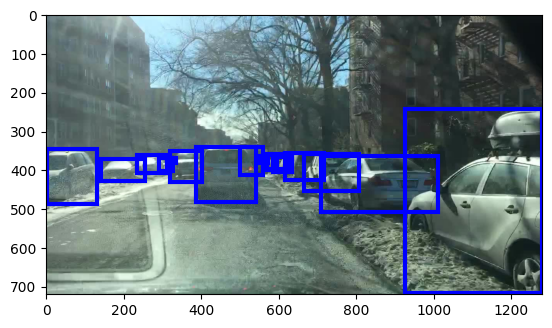

Showing 20 proposals (requested top 20)


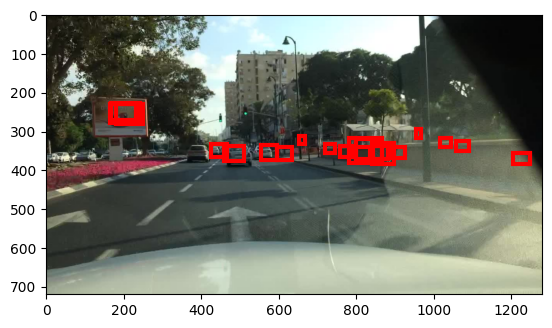

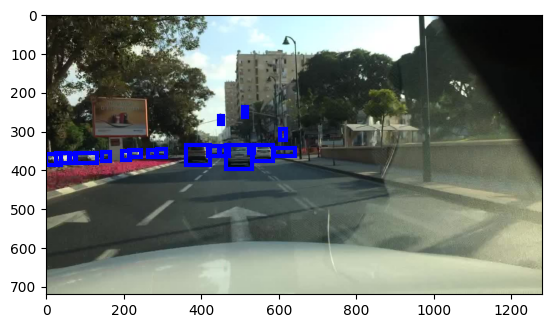

Showing 20 proposals (requested top 20)


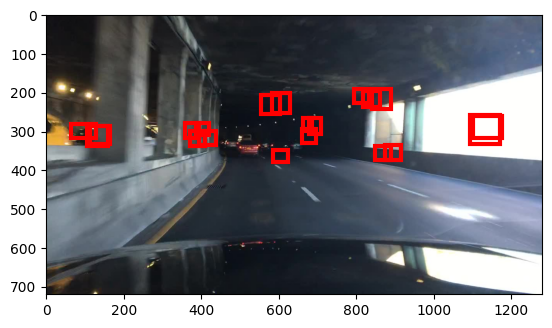

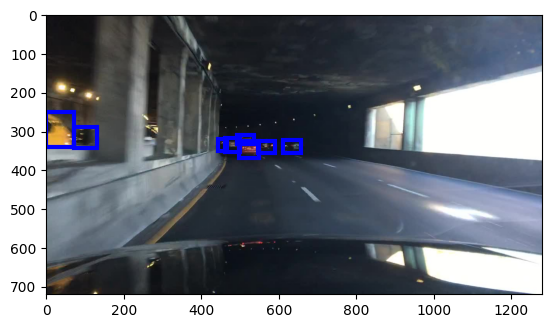

Validation on validation data:
Showing 20 proposals (requested top 20)


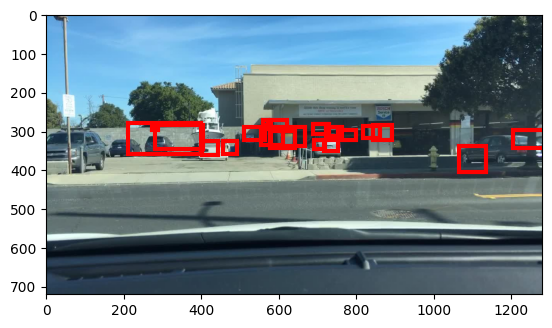

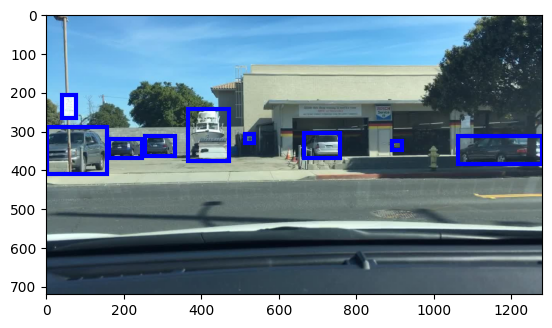

Showing 20 proposals (requested top 20)


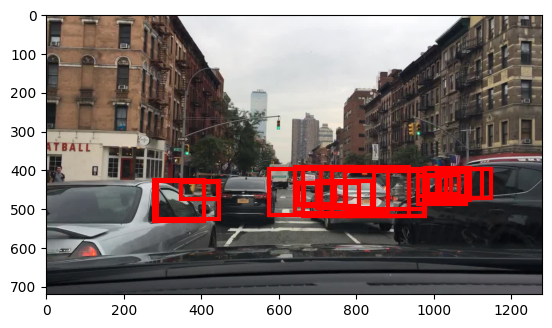

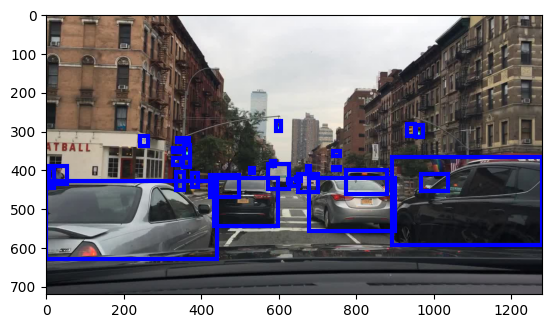

Showing 20 proposals (requested top 20)


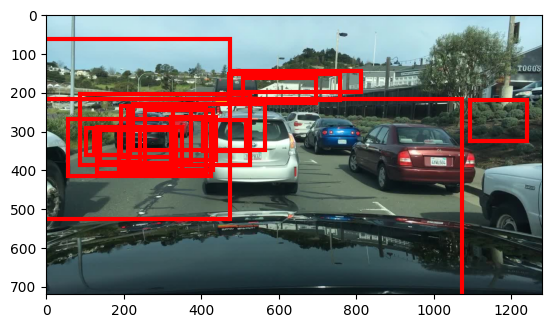

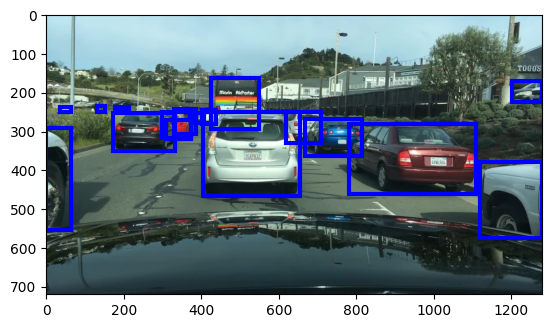

Showing 20 proposals (requested top 20)


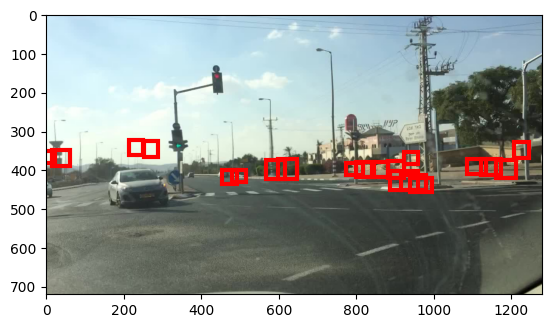

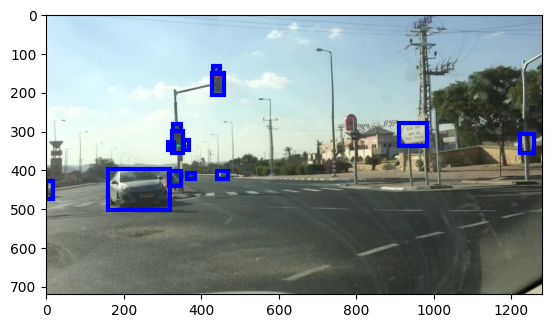

Showing 20 proposals (requested top 20)


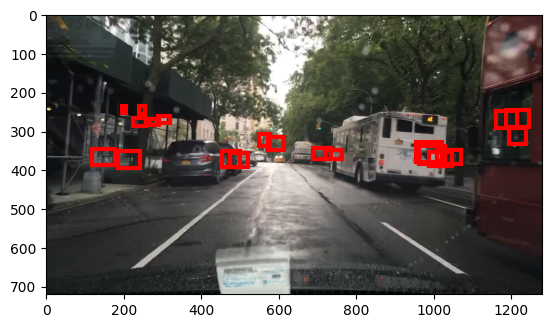

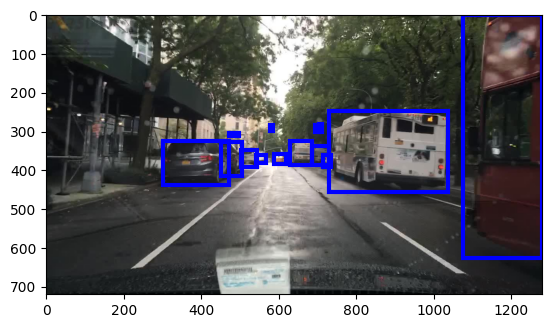

Showing 20 proposals (requested top 20)


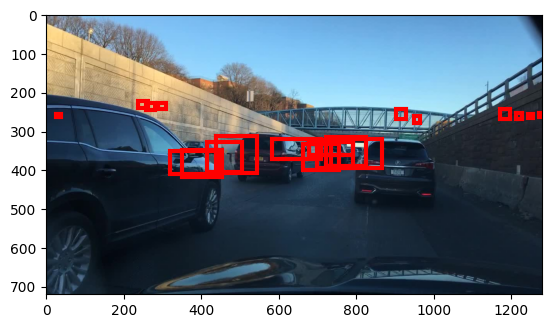

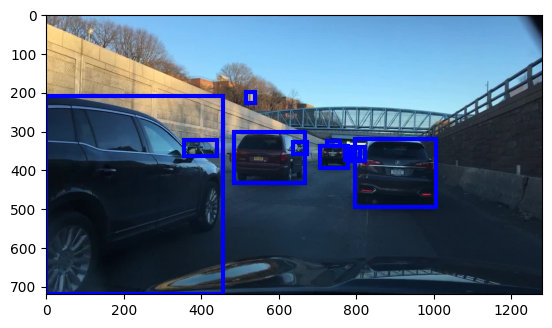

Showing 20 proposals (requested top 20)


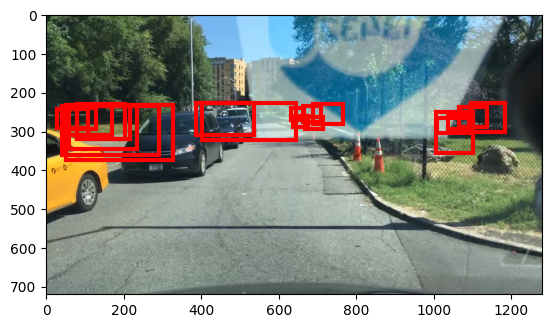

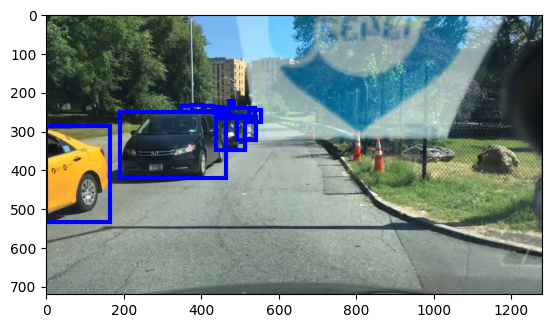

In [ ]:
# Train the RPN using the training DataLoader
trained_rpn = train_epochs(req_features, rpn_model, optimizer, small_train_loader, epochs=5, rpn_lambda=10)

# Validate (visualize predictions) on both training and validation sets
print("Validation on training data:")
validate(trained_rpn, train_loader)
print("Validation on validation data:")
validate(trained_rpn, val_loader)

###ROI

In [ ]:
import torchvision.ops as ops
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torchvision.ops as ops

class ROIPooling(nn.Module):
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple or int): Size of the output (height, width)
        """
        super(ROIPooling, self).__init__()
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size

    def forward(self, features, rois):
        """
        Args:
            features (Tensor): Input features of shape (N, C, H, W)
            rois (Tensor): Regions of Interest in format
                          [batch_index, x1, y1, x2, y2] with shape (K, 5)

        Returns:
            Pooled features of shape (K, C, output_size[0], output_size[1])
        """
        # Ensure rois are on same device as features
        rois = rois.to(features.device)

        # Calculate spatial scale (feature map size / original image size)
        spatial_scale_h = features.size(2) / 224  # Assuming input image size is 224
        spatial_scale_w = features.size(3) / 224
        spatial_scale = min(spatial_scale_h, spatial_scale_w)

        # Perform ROI pooling
        pooled_features = ops.roi_pool(
            features,
            rois,
            output_size=self.output_size,
            spatial_scale=spatial_scale
        )

        return pooled_features

    def __repr__(self):
        return self.__class__.__name__ + '(output_size={})'.format(self.output_size)



class RPNWithROI(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9, roi_size=(7,7)):
        super(RPNWithROI, self).__init__()
        # Original RPN layers
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor*4, kernel_size=1, stride=1)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor*2, kernel_size=1, stride=1)

        # ROI Pooling layer
        self.roi_pool = ops.RoIPool(roi_size, spatial_scale=1.0)

        # Initialize weights
        for layer in [self.conv1, self.reg_layer, self.cls_layer]:
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x, anchors=None, gt_boxes=None):
        # Original RPN forward pass
        batch_size = x.shape[0]
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)  # [B, n_anchor*4, H, W]
        pred_cls_scores = self.cls_layer(x)   # [B, n_anchor*2, H, W]

        # Reshape outputs
        pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(batch_size, -1, 4)  # [B, H*W*n_anchor, 4]
        pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous().view(batch_size, -1, 2)     # [B, H*W*n_anchor, 2]
        objectness_score = pred_cls_scores[:,:,1]  # [B, H*W*n_anchor]

        if anchors is not None and gt_boxes is not None:
            # Convert predictions to boxes
            proposal_boxes = self._generate_proposals(pred_anchor_locs, anchors)  # [B, H*W*n_anchor, 4]

            # Perform NMS and ROI pooling
            pooled_features = self._process_proposals(x, proposal_boxes, objectness_score)
            return pred_anchor_locs, pred_cls_scores, objectness_score, pooled_features

        return pred_anchor_locs, pred_cls_scores, objectness_score

    def _generate_proposals(self, pred_locs, anchors):
        """Convert anchor offsets to boxes in (x1,y1,x2,y2) format"""
        # pred_locs: [B, N, 4] (dy, dx, dh, dw)
        # anchors: [N, 4] (y1, x1, y2, x2)
        proposals = torch.zeros_like(pred_locs)

        # Convert anchors to (ctr_y, ctr_x, h, w)
        anchors_cpu = anchors.cpu()
        anchor_h = anchors[:, 2] - anchors[:, 0]
        anchor_w = anchors[:, 3] - anchors[:, 1]
        anchor_ctr_y = anchors[:, 0] + 0.5 * anchor_h
        anchor_ctr_x = anchors[:, 1] + 0.5 * anchor_w

        # Apply predictions
        dy = pred_locs[..., 0]
        dx = pred_locs[..., 1]
        dh = pred_locs[..., 2]
        dw = pred_locs[..., 3]

        ctr_y = dy * anchor_h[None, :] + anchor_ctr_y[None, :]
        ctr_x = dx * anchor_w[None, :] + anchor_ctr_x[None, :]
        h = torch.exp(dh) * anchor_h[None, :]
        w = torch.exp(dw) * anchor_w[None, :]

        # Convert back to (x1,y1,x2,y2)
        proposals[..., 0] = ctr_x - 0.5 * w  # x1
        proposals[..., 1] = ctr_y - 0.5 * h  # y1
        proposals[..., 2] = ctr_x + 0.5 * w  # x2
        proposals[..., 3] = ctr_y + 0.5 * h  # y2

        return proposals

    def _process_proposals(self, features, boxes, scores, conf_thresh=0.7, iou_thresh=0.5, top_n=50):
        """Process proposals through NMS and ROI pooling"""
        batch_size = features.shape[0]
        pooled_features = []

        for i in range(batch_size):
            # Filter by confidence
            mask = scores[i] > conf_thresh
            filtered_boxes = boxes[i][mask]
            filtered_scores = scores[i][mask]

            if len(filtered_boxes) > 0:
                # Apply NMS
                keep = ops.nms(filtered_boxes, filtered_scores, iou_thresh)
                final_boxes = filtered_boxes[keep][:top_n]

                # Format for ROI pooling [batch_idx, x1, y1, x2, y2]
                roi_input = torch.cat([
                    torch.full((len(final_boxes), 1), i, dtype=torch.float32, device=features.device),
                    final_boxes
                ], dim=1)

                # ROI Pooling
                pooled = self.roi_pool(features[i:i+1], roi_input)  # Maintain batch dim
                pooled_features.append(pooled)
            else:
                pooled_features.append(torch.empty(0, device=features.device))

        return torch.cat(pooled_features, dim=0) if batch_size > 1 else pooled_features[0]

def combine_boxes(boxes, scores=None, iou_threshold=0.5, min_cluster_size=2):
    # Convert to numpy if needed (maintaining [y1,x1,y2,x2] format)
    boxes_np = boxes.cpu().numpy() if isinstance(boxes, torch.Tensor) else np.array(boxes)

    if len(boxes_np) == 0:
        return boxes, np.array([])

    # Calculate IoU matrix using your existing function
    iou_matrix = compute_iou_vectorized(boxes_np, boxes_np)  # Compare all boxes to all boxes

    # Convert IoU to distance (1-IoU) for DBSCAN
    distance_matrix = 1 - iou_matrix

    # Cluster boxes using DBSCAN
    clustering = DBSCAN(
        eps=1-iou_threshold,
        min_samples=min_cluster_size,
        metric='precomputed'
    ).fit(distance_matrix)

    cluster_labels = clustering.labels_

    # Combine boxes in each cluster
    combined_boxes = []
    for cluster_id in np.unique(cluster_labels):
        if cluster_id == -1:  # Skip noise points (boxes not in any cluster)
            continue

        cluster_mask = (cluster_labels == cluster_id)
        cluster_boxes = boxes_np[cluster_mask]

        # Calculate combined box coordinates (still in [y1,x1,y2,x2] format)
        y1 = np.min(cluster_boxes[:, 0])
        x1 = np.min(cluster_boxes[:, 1])
        y2 = np.max(cluster_boxes[:, 2])
        x2 = np.max(cluster_boxes[:, 3])
        combined_boxes.append([y1, x1, y2, x2])

    # Add unclustered boxes (if any)
    unclustered_mask = (cluster_labels == -1)
    if np.any(unclustered_mask):
        combined_boxes.extend(boxes_np[unclustered_mask])

    combined_boxes = np.array(combined_boxes) if len(combined_boxes) > 0 else np.empty((0, 4))

    # Convert back to tensor if input was tensor
    if isinstance(boxes, torch.Tensor):
        combined_boxes = torch.from_numpy(combined_boxes).float().to(boxes.device)

    return combined_boxes, cluster_labels


def train_epochs(req_features, rpn_model, optimizer, train_dl, epochs=20, rpn_lambda=10, device=None):
    if device is None:  # If device is not specified, use the default device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rpn_model.train()
    for epoch in range(epochs):
        total_samples = 0
        sum_loss = 0.0
        sum_loss_cls = 0.0
        sum_loss_loc = 0.0
        for batch in train_dl:
            images = batch["images"].to(device) # shape (B,C,H,W)
            targets = [{"boxes": b, "labels": l} for b, l in zip(batch["boxes"], batch["labels"])]
            B = images.shape[0]
            #print(f"image size: {B}")
            total_samples += B
            # Forward through frozen backbone
            imgs = images.clone()
            with torch.no_grad():
                feat = imgs
                for m in req_features:
                    feat = m(feat)
            X_FM, Y_FM = feat.shape[2], feat.shape[3]
            # Compute GT targets (for all anchors)
            gt_locs_np, gt_scores_np, anchors = bbox_generation([img for img in images], targets, X_FM, Y_FM)
            print("Hmm")
            gt_locs = torch.from_numpy(gt_locs_np.astype(np.float32)).to(device)
            gt_scores = torch.from_numpy(gt_scores_np.astype(np.float32)).to(device)
            # Forward RPN
            pred_locs, pred_scores, objectness_score = rpn_model(feat)
            # Compute classification loss: flatten predictions and GT.
            cls_loss = F.cross_entropy(pred_scores.view(-1,2),
                                       gt_scores.view(-1).long(),
                                       ignore_index=-1)
            # Compute regression loss for positive anchors only.
            pos_mask = gt_scores > 0
            if pos_mask.sum() > 0:
                pred_pos = pred_locs[pos_mask]
                gt_pos = gt_locs[pos_mask]
                diff = torch.abs(gt_pos - pred_pos)
                loc_loss = torch.where(diff < 1, 0.5 * diff**2, diff - 0.5)
                loc_loss = loc_loss.sum() / pos_mask.sum().float()
            else:
                loc_loss = torch.tensor(0.0, device=device)
            loss = cls_loss + rpn_lambda * loc_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Logging
            sum_loss += loss.item() * B
            sum_loss_cls += cls_loss.item() * B
            sum_loss_loc += (rpn_lambda * loc_loss.item()) * B

        # Epoch summary
        avg_loss = sum_loss / total_samples
        avg_cls = sum_loss_cls / total_samples
        avg_loc = sum_loss_loc / total_samples
        print(f"Epoch {epoch+1}/{epochs}: Loss {avg_loss:.3f} | Cls {avg_cls:.3f} | Loc {avg_loc:.3f}")

        # Save checkpoint
        if (epoch+1) % 5 == 0:
            torch.save(rpn_model.state_dict(), f"./rpn_epoch_{epoch+1}.pth")

    return rpn_model

def validate(rpn_model, data_loader, n_images=15, top_k=20, conf_thresh=0.5, iou_thresh=0.5, combine_thresh=0.4):
    rpn_model.eval()
    roi_pool = ROIPooling(output_size=(14, 14)).to(device)

    with torch.no_grad():
        batch = next(iter(data_loader))
        images = batch["images"][:n_images].to(device)
        targets = [{"boxes": b.to(device), "labels": l.to(device)}
                 for b, l in zip(batch["boxes"], batch["labels"])][:n_images]

        # Forward pass
        imgs = images.clone()
        for m in req_features:
            imgs = m(imgs)

        X_FM, Y_FM = imgs.shape[2], imgs.shape[3]
        _, _, anchors_np = bbox_generation([img for img in images], targets, X_FM, Y_FM)
        anchors = torch.from_numpy(anchors_np).float().to(device)

        pred_locs, pred_scores, objectness_score = rpn_model(imgs)

        for i in range(min(n_images, images.shape[0])):
            # 1. Convert predictions to boxes
            rois_xyxy_np = pred_bbox_to_xywh(pred_locs[i].cpu(), anchors.cpu().numpy())
            rois_xyxy = torch.from_numpy(rois_xyxy_np).float().to(device)

            # 2. Select top-k highest scoring proposals
            if top_k:
                k = min(top_k, len(objectness_score[i]))
                top_k_idx = torch.topk(objectness_score[i], k=k).indices
                top_k_boxes = rois_xyxy[top_k_idx]
                top_k_scores = objectness_score[i][top_k_idx]
            else:
                top_k_boxes = rois_xyxy
                top_k_scores = objectness_score[i]

            # 3. Confidence threshold filtering
            conf_mask = top_k_scores > conf_thresh
            filtered_boxes = top_k_boxes[conf_mask]
            filtered_scores = top_k_scores[conf_mask]

            if len(filtered_boxes) > 0:
                # 4. ROI Pooling on filtered boxes
                roi_input = torch.cat([
                    torch.zeros((len(filtered_boxes), 1), device=device),
                    filtered_boxes
                ], dim=1)
                pooled_features = roi_pool(imgs[i].unsqueeze(0), roi_input)

                # 5. Combine boxes after ROI pooling
                combined_boxes, _ = combine_boxes(
                    filtered_boxes[:, [1, 0, 3, 2]],  # Convert to [y1,x1,y2,x2]
                    iou_threshold=combine_thresh,
                    min_cluster_size=2
                )

                combined_boxes = combined_boxes[:, [1, 0, 3, 2]]  # Back to [x1,y1,x2,y2]

                print(f"Original {len(filtered_boxes)} proposals → Combined to {len(combined_boxes)} boxes")

                # Visualization of final combined proposals
                show_corner_bbs(images[i].cpu(), combined_boxes.cpu().numpy())

                if len(targets[i]["boxes"]) > 0:
                    show_ground_truth_bbs(images[i].cpu(), targets[i]["boxes"].cpu().numpy())
            else:
                print(f"No proposals met confidence threshold {conf_thresh} for image {i}")

    rpn_model.train()

In [ ]:
# Initialize and run training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load and prepare VGG backbone
vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
vgg_model.eval()

# Freeze VGG features
for param in vgg_model.features.parameters():
    param.requires_grad = False
req_features = [layer for layer in list(vgg_model.features)[:30]]

# 2. Create a wrapper for the backbone features
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layers):
        super().__init__()
        self.features = nn.Sequential(*feature_layers)

    def forward(self, x):
        return self.features(x)

# 3. Define the Detection Head
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes, roi_size=(7,7)):
        super().__init__()
        self.fc1 = nn.Linear(in_channels * roi_size[0] * roi_size[1], 1024)
        self.fc2 = nn.Linear(1024, 1024)

        # Classifier branch
        self.cls_score = nn.Linear(1024, num_classes)

        # Bounding box regressor branch (4 coordinates per class)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

        # Initialize weights
        for layer in [self.fc1, self.fc2, self.cls_score, self.bbox_pred]:
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_logits = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return cls_logits, bbox_deltas

# 4. Create the complete TwoStageDetector
class TwoStageDetector(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9, roi_size=(7,7), num_classes=20):
        super(TwoStageDetector, self).__init__()
        # RPN components (same as before)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor*4, kernel_size=1, stride=1)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor*2, kernel_size=1, stride=1)

        # ROI Pooling layer
        self.roi_pool = ops.RoIPool(roi_size, spatial_scale=1.0)

        # Detection head components
        self.num_classes = num_classes
        self.detection_head = nn.Sequential(
            nn.Linear(in_channels * roi_size[0] * roi_size[1], 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU()
        )
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

        # Initialize weights
        for layer in [self.conv1, self.reg_layer, self.cls_layer]:
            nn.init.normal_(layer.weight, std=0.01)
            nn.init.constant_(layer.bias, 0)

        for layer in [self.detection_head, self.cls_score, self.bbox_pred]:
            if hasattr(layer, 'weight'):
                nn.init.normal_(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)

    def forward(self, x, anchors=None, gt_boxes=None):
        # Original RPN forward pass
        batch_size = x.shape[0]
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)  # [B, n_anchor*4, H, W]
        pred_cls_scores = self.cls_layer(x)   # [B, n_anchor*2, H, W]

        # Reshape outputs
        pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(batch_size, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous().view(batch_size, -1, 2)
        objectness_score = pred_cls_scores[:,:,1]

        if anchors is not None and gt_boxes is not None:
            # Generate proposals
            proposal_boxes = self._generate_proposals(pred_anchor_locs, anchors)

            # Process proposals through NMS and ROI pooling
            pooled_features = self._process_proposals(x, proposal_boxes, objectness_score)

            if pooled_features.size(0) > 0:
                # Flatten features for detection head
                pooled_flat = pooled_features.view(pooled_features.size(0), -1)

                # Detection head forward pass
                features = self.detection_head(pooled_flat)
                cls_logits = self.cls_score(features)
                bbox_deltas = self.bbox_pred(features)

                return {
                    'rpn_locs': pred_anchor_locs,
                    'rpn_scores': pred_cls_scores,
                    'proposals': proposal_boxes,
                    'cls_logits': cls_logits,
                    'bbox_deltas': bbox_deltas,
                    'pooled_features': pooled_features
                }
            else:
                return {
                    'rpn_locs': pred_anchor_locs,
                    'rpn_scores': pred_cls_scores,
                    'proposals': proposal_boxes,
                    'cls_logits': None,
                    'bbox_deltas': None,
                    'pooled_features': None
                }

        return pred_anchor_locs, pred_cls_scores, objectness_score

    # Keep all your existing helper methods
    def _generate_proposals(self, pred_locs, anchors):
        """Same as your original implementation"""
        proposals = torch.zeros_like(pred_locs)

        anchor_h = anchors[:, 2] - anchors[:, 0]
        anchor_w = anchors[:, 3] - anchors[:, 1]
        anchor_ctr_y = anchors[:, 0] + 0.5 * anchor_h
        anchor_ctr_x = anchors[:, 1] + 0.5 * anchor_w

        dy = pred_locs[..., 0]
        dx = pred_locs[..., 1]
        dh = pred_locs[..., 2]
        dw = pred_locs[..., 3]

        ctr_y = dy * anchor_h[None, :] + anchor_ctr_y[None, :]
        ctr_x = dx * anchor_w[None, :] + anchor_ctr_x[None, :]
        h = torch.exp(dh) * anchor_h[None, :]
        w = torch.exp(dw) * anchor_w[None, :]

        proposals[..., 0] = ctr_x - 0.5 * w
        proposals[..., 1] = ctr_y - 0.5 * h
        proposals[..., 2] = ctr_x + 0.5 * w
        proposals[..., 3] = ctr_y + 0.5 * h

        return proposals

    def _process_proposals(self, features, boxes, scores, conf_thresh=0.7, iou_thresh=0.5, top_n=50):
        """Same as your original implementation"""
        batch_size = features.shape[0]
        pooled_features = []

        for i in range(batch_size):
            mask = scores[i] > conf_thresh
            filtered_boxes = boxes[i][mask]
            filtered_scores = scores[i][mask]

            if len(filtered_boxes) > 0:
                keep = ops.nms(filtered_boxes, filtered_scores, iou_thresh)
                final_boxes = filtered_boxes[keep][:top_n]

                roi_input = torch.cat([
                    torch.full((len(final_boxes), 1), i, dtype=torch.float32, device=features.device),
                    final_boxes
                ], dim=1)

                pooled = self.roi_pool(features[i:i+1], roi_input)
                pooled_features.append(pooled)
            else:
                pooled_features.append(torch.empty(0, device=features.device))

        return torch.cat(pooled_features, dim=0) if batch_size > 1 else pooled_features[0]

backbone = VGGFeatureExtractor(req_features).to(device)
rpn = RPNWithROI().to(device)
num_classes = 20  # Set your number of classes
detector = TwoStageDetector(in_channels=512,  # <-- Pass the correct in_channels value
                           mid_channels=512,
                           n_anchor=9,
                           roi_size=(7, 7),
                           num_classes=num_classes).to(device)

# 6. Create optimizer for all parameters
optimizer = torch.optim.Adam([
    {'params': rpn.parameters()},
    {'params': detector.detection_head.parameters()}
], lr=0.0005)

def train_detector(detector, optimizer, train_loader, num_classes, epochs=5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    detector.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_rpn_cls_loss = 0.0
        epoch_rpn_reg_loss = 0.0
        epoch_det_cls_loss = 0.0
        epoch_det_reg_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            # 1. Prepare data
            images = batch["images"].to(device)
            targets = [{"boxes": b.to(device), "labels": l.to(device)}
                      for b, l in zip(batch["boxes"], batch["labels"])]

            # 2. Forward pass
            outputs = detector(images, targets)

            # 3. Compute losses
            losses = compute_detector_loss(
                rpn_outputs={
                    'rpn_locs': outputs['rpn_locs'],
                    'rpn_scores': outputs['rpn_scores']
                },
                detection_outputs={
                    'cls_logits': outputs.get('cls_logits'),
                    'bbox_deltas': outputs.get('bbox_deltas'),
                    'proposals': outputs.get('proposals')
                },
                targets=targets,
                num_classes=num_classes
            )

            # 4. Backward pass and optimize
            optimizer.zero_grad()
            losses['total_loss'].backward()
            optimizer.step()

            # 5. Accumulate losses for logging
            epoch_loss += losses['total_loss'].item()
            epoch_rpn_cls_loss += losses['rpn_cls_loss'].item()
            epoch_rpn_reg_loss += losses['rpn_reg_loss'].item()
            epoch_det_cls_loss += losses['det_cls_loss'].item()
            epoch_det_reg_loss += losses['det_reg_loss'].item()

            # Print batch statistics
            if batch_idx % 50 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | '
                      f'Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {losses["total_loss"].item():.4f} | '
                      f'RPN Cls: {losses["rpn_cls_loss"].item():.4f} | '
                      f'RPN Reg: {losses["rpn_reg_loss"].item():.4f} | '
                      f'Det Cls: {losses["det_cls_loss"].item():.4f} | '
                      f'Det Reg: {losses["det_reg_loss"].item():.4f}')

        # 6. Print epoch statistics
        avg_loss = epoch_loss / len(train_loader)
        avg_rpn_cls = epoch_rpn_cls_loss / len(train_loader)
        avg_rpn_reg = epoch_rpn_reg_loss / len(train_loader)
        avg_det_cls = epoch_det_cls_loss / len(train_loader)
        avg_det_reg = epoch_det_reg_loss / len(train_loader)

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Total Loss: {avg_loss:.4f}')
        print(f'RPN Classification: {avg_rpn_cls:.4f}')
        print(f'RPN Regression: {avg_rpn_reg:.4f}')
        print(f'Detection Classification: {avg_det_cls:.4f}')
        print(f'Detection Regression: {avg_det_reg:.4f}\n')

        # 7. Save checkpoint
        if (epoch + 1) % 2 == 0:
            checkpoint_path = f'detector_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': detector.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f'Saved checkpoint to {checkpoint_path}')

    return detector



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def match_proposals_to_targets(proposals, targets, pos_iou_thresh=0.5, neg_iou_thresh=0.3):
    """
    Match proposals to ground truth boxes and compute regression targets

    Args:
        proposals: Tensor of shape (N, 5) [batch_idx, x1, y1, x2, y2]
        targets: List of dicts with 'boxes' and 'labels'

    Returns:
        matched_gt_boxes: Tensor of shape (N, 4) with regression targets
        matched_gt_labels: Tensor of shape (N,) with class labels (0=bg)
    """
    batch_size = len(targets)
    all_matched_boxes = []
    all_matched_labels = []

    for i in range(batch_size):
        # Get proposals and GT boxes for this image
        img_proposals = proposals[proposals[:, 0] == i][:, 1:]
        gt_boxes = targets[i]['boxes']
        gt_labels = targets[i]['labels']

        if len(gt_boxes) == 0:
            # No GT boxes - all proposals are background
            matched_boxes = torch.zeros_like(img_proposals)
            matched_labels = torch.zeros(len(img_proposals), dtype=torch.long,
                                      device=img_proposals.device)
        else:
            # Calculate IoU between proposals and GT boxes
            iou = ops.box_iou(img_proposals, gt_boxes)

            # For each proposal, get best matching GT box
            max_iou, best_gt_idx = iou.max(dim=1)

            # Determine positive/negative samples
            pos_mask = max_iou >= pos_iou_thresh
            neg_mask = max_iou < neg_iou_thresh
            ignore_mask = ~(pos_mask | neg_mask)

            # Get matched boxes and labels
            matched_boxes = gt_boxes[best_gt_idx]
            matched_labels = gt_labels[best_gt_idx]

            # Set background for negative samples
            matched_labels[neg_mask | ignore_mask] = 0

            # For positive samples, calculate box deltas
            matched_boxes[pos_mask] = boxes_to_deltas(
                img_proposals[pos_mask],
                matched_boxes[pos_mask]
            )

        all_matched_boxes.append(matched_boxes)
        all_matched_labels.append(matched_labels)

    return torch.cat(all_matched_boxes), torch.cat(all_matched_labels)

def boxes_to_deltas(proposals, gt_boxes):
    """
    Convert box coordinates to regression targets (dx, dy, dw, dh)
    """
    proposals = proposals.float()
    gt_boxes = gt_boxes.float()

    # Calculate center coordinates and dimensions
    p_widths = proposals[:, 2] - proposals[:, 0]
    p_heights = proposals[:, 3] - proposals[:, 1]
    p_ctr_x = proposals[:, 0] + 0.5 * p_widths
    p_ctr_y = proposals[:, 1] + 0.5 * p_heights

    g_widths = gt_boxes[:, 2] - gt_boxes[:, 0]
    g_heights = gt_boxes[:, 3] - gt_boxes[:, 1]
    g_ctr_x = gt_boxes[:, 0] + 0.5 * g_widths
    g_ctr_y = gt_boxes[:, 1] + 0.5 * g_heights

    # Calculate deltas
    dx = (g_ctr_x - p_ctr_x) / p_widths
    dy = (g_ctr_y - p_ctr_y) / p_heights
    dw = torch.log(g_widths / p_widths)
    dh = torch.log(g_heights / p_heights)

    return torch.stack([dx, dy, dw, dh], dim=1)

In [ ]:
def compute_detector_loss(rpn_outputs, detection_outputs, targets, num_classes, rpn_lambda=10, cls_lambda=1.0):
    """
    Compute combined RPN and detection losses

    Args:
        rpn_outputs: dict with 'rpn_locs' and 'rpn_scores'
        detection_outputs: dict with 'cls_logits' and 'bbox_deltas'
        targets: list of dicts with 'boxes' and 'labels'
        num_classes: number of target classes
    """
    device = rpn_outputs['rpn_locs'].device

    # 1. RPN Losses
    # Generate anchor targets (you'll need your existing bbox_generation function)
    gt_locs_np, gt_scores_np, anchors = bbox_generation(
        [t['boxes'].cpu().numpy() for t in targets],
        [t['labels'].cpu().numpy() for t in targets],
        rpn_outputs['rpn_locs'].shape[2],  # Feature map height
        rpn_outputs['rpn_locs'].shape[3]   # Feature map width
    )

    gt_locs = torch.from_numpy(gt_locs_np).float().to(device)
    gt_scores = torch.from_numpy(gt_scores_np).float().to(device)

    # RPN classification loss
    rpn_cls_loss = F.cross_entropy(
        rpn_outputs['rpn_scores'].view(-1, 2),
        gt_scores.view(-1).long(),
        ignore_index=-1
    )

    # RPN regression loss (only positive anchors)
    pos_mask = gt_scores > 0
    if pos_mask.sum() > 0:
        pred_pos = rpn_outputs['rpn_locs'].view(-1, 4)[pos_mask]
        gt_pos = gt_locs.view(-1, 4)[pos_mask]
        rpn_reg_loss = F.smooth_l1_loss(pred_pos, gt_pos, reduction='sum') / pos_mask.sum().float()
    else:
        rpn_reg_loss = torch.tensor(0.0, device=device)

    # 2. Detection Losses
    if 'cls_logits' in detection_outputs and detection_outputs['cls_logits'] is not None:
        # Match proposals to ground truth
        matched_gt_boxes, matched_gt_labels = match_proposals_to_targets(
            detection_outputs['proposals'],
            targets,
            pos_iou_thresh=0.5,
            neg_iou_thresh=0.3
        )

        # Classification loss
        cls_loss = F.cross_entropy(
            detection_outputs['cls_logits'],
            matched_gt_labels.long()
        )

        # Regression loss (only positive samples)
        pos_mask = matched_gt_labels > 0
        if pos_mask.sum() > 0:
            # Get class-specific predictions
            pred_deltas = detection_outputs['bbox_deltas'].view(-1, num_classes, 4)
            pred_deltas = pred_deltas[torch.arange(len(pred_deltas)), matched_gt_labels]

            # Get ground truth deltas
            gt_deltas = matched_gt_boxes[pos_mask]

            reg_loss = F.smooth_l1_loss(
                pred_deltas[pos_mask],
                gt_deltas,
                reduction='sum'
            ) / pos_mask.sum().float()
        else:
            reg_loss = torch.tensor(0.0, device=device)
    else:
        cls_loss = torch.tensor(0.0, device=device)
        reg_loss = torch.tensor(0.0, device=device)

    # 3. Combine losses
    total_loss = (rpn_cls_loss + rpn_lambda * rpn_reg_loss +
                 cls_lambda * (cls_loss + reg_loss))

    return {
        'total_loss': total_loss,
        'rpn_cls_loss': rpn_cls_loss,
        'rpn_reg_loss': rpn_reg_loss,
        'det_cls_loss': cls_loss,
        'det_reg_loss': reg_loss
    }

In [ ]:
def validate(detector, data_loader, n_images=15, top_k=20,
             conf_thresh=0.5, iou_thresh=0.5, combine_thresh=0.4,
             cls_thresh=0.5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    detector.eval()

    with torch.no_grad():
        batch = next(iter(data_loader))
        images = batch["images"][:n_images].to(device)
        targets = [{"boxes": b.to(device), "labels": l.to(device)}
                 for b, l in zip(batch["boxes"], batch["labels"])][:n_images]

        # Forward pass through backbone
        features = detector.conv1(images)  # Get features after first conv

        # Get feature map dimensions
        X_FM, Y_FM = features.shape[2], features.shape[3]

        # Generate anchors
        _, _, anchors_np = bbox_generation([img.cpu() for img in images],
                                         [{'boxes': t['boxes'].cpu(), 'labels': t['labels'].cpu()}
                                          for t in targets],
                                         X_FM, Y_FM)
        anchors = torch.from_numpy(anchors_np).float().to(device)

        # Full forward pass through detector
        outputs = detector(features, anchors=anchors, gt_boxes=targets)

        for i in range(min(n_images, images.shape[0])):
            # Get proposals for this image
            img_proposals = outputs['proposals'][outputs['proposals'][:, 0] == i]
            img_scores = outputs['rpn_scores'][i, :, 1]  # Objectness scores

            # Select top-k highest scoring proposals
            if top_k:
                k = min(top_k, len(img_scores))
                top_k_idx = torch.topk(img_scores, k=k).indices
                proposal_boxes = img_proposals[top_k_idx, 1:]  # Remove batch index
                proposal_scores = img_scores[top_k_idx]
            else:
                proposal_boxes = img_proposals[:, 1:]
                proposal_scores = img_scores

            # Confidence threshold filtering
            conf_mask = proposal_scores > conf_thresh
            filtered_boxes = proposal_boxes[conf_mask]
            filtered_scores = proposal_scores[conf_mask]

            print(f"Image {i}: {len(combined_boxes)} proposals (no class predictions)")
            show_corner_bbs(images[i].cpu(), combined_boxes.cpu().numpy())

            # Show ground truth if available
            if len(targets[i]["boxes"]) > 0:
                show_ground_truth_bbs(
                        images[i].cpu(),
                        targets[i]["boxes"].cpu().numpy(),
                        targets[i]["labels"].cpu().numpy()
                    )
            else:
                print(f"No proposals met confidence threshold {conf_thresh} for image {i}")

    detector.train()

In [ ]:
def match_proposals_to_targets(proposals, targets, pos_iou_thresh=0.5, neg_iou_thresh=0.3):
    """
    Match proposals to ground truth boxes and compute regression targets

    Args:
        proposals: Tensor of shape (N, 5) [batch_idx, x1, y1, x2, y2]
        targets: List of dicts with 'boxes' and 'labels'

    Returns:
        matched_gt_boxes: Tensor of shape (N, 4) with regression targets
        matched_gt_labels: Tensor of shape (N,) with class labels (0=bg)
    """
    batch_size = len(targets)
    all_matched_boxes = []
    all_matched_labels = []

    # Ensure proposals have correct shape [N,5]
    if proposals.dim() == 3:
        # Convert from [B, N, 4] to [N, 5] format
        B, N = proposals.shape[:2]
        batch_indices = torch.arange(B, device=proposals.device).unsqueeze(1).expand(B, N)
        proposals = torch.cat([
            batch_indices.reshape(-1, 1),
            proposals.reshape(-1, 4)
        ], dim=1)

    for i in range(batch_size):
        # Get proposals and GT boxes for this image
        img_mask = proposals[:, 0] == i
        img_proposals = proposals[img_mask, 1:]  # Remove batch index
        gt_boxes = targets[i]['boxes']
        gt_labels = targets[i]['labels']

        if len(gt_boxes) == 0:
            # No GT boxes - all proposals are background
            matched_boxes = torch.zeros_like(img_proposals)
            matched_labels = torch.zeros(len(img_proposals), dtype=torch.long,
                                      device=img_proposals.device)
        else:
            # Calculate IoU between proposals and GT boxes
            iou = ops.box_iou(img_proposals, gt_boxes)

            # For each proposal, get best matching GT box
            max_iou, best_gt_idx = iou.max(dim=1)

            # Determine positive/negative samples
            pos_mask = max_iou >= pos_iou_thresh
            neg_mask = max_iou < neg_iou_thresh
            ignore_mask = ~(pos_mask | neg_mask)

            # Get matched boxes and labels
            matched_boxes = gt_boxes[best_gt_idx]
            matched_labels = gt_labels[best_gt_idx]

            # Set background for negative samples
            matched_labels[neg_mask | ignore_mask] = 0

            # For positive samples, calculate box deltas
            matched_boxes[pos_mask] = boxes_to_deltas(
                img_proposals[pos_mask],
                matched_boxes[pos_mask]
            )

        all_matched_boxes.append(matched_boxes)
        all_matched_labels.append(matched_labels)

    return torch.cat(all_matched_boxes), torch.cat(all_matched_labels)


def train_full_model(detector, optimizer, train_loader, val_loader, num_classes,
                    epochs=20, rpn_lambda=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        detector.train()
        total_loss = 0.0
        total_samples = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch["images"].to(device)
            targets = [{"boxes": b.to(device), "labels": l.to(device)}
                      for b, l in zip(batch["boxes"], batch["labels"])]

            B = images.shape[0]
            total_samples += B

            # Forward through backbone
            with torch.no_grad():
                features = detector.backbone(images)

            # Get feature map dimensions
            X_FM, Y_FM = features.shape[2], features.shape[3]

            # Compute anchor targets
            gt_locs_np, gt_scores_np, anchors = bbox_generation(
                [img.cpu() for img in images],
                [{'boxes': t['boxes'].cpu(), 'labels': t['labels'].cpu()} for t in targets],
                X_FM, Y_FM
            )
            gt_locs = torch.from_numpy(gt_locs_np).float().to(device)
            gt_scores = torch.from_numpy(gt_scores_np).float().to(device)
            anchors = torch.from_numpy(anchors).float().to(device)

            # Forward pass through detector
            outputs = detector(features, anchors=anchors, gt_boxes=targets)

            # Reshape RPN outputs
            rpn_locs = outputs['rpn_locs'].view(B, -1, 4)  # [B, num_anchors, 4]
            rpn_scores = outputs['rpn_scores'].view(B, -1, 2)  # [B, num_anchors, 2]

            # RPN classification loss
            rpn_cls_loss = F.cross_entropy(
                rpn_scores.view(-1, 2),
                gt_scores.view(-1).long(),
                ignore_index=-1
            )

            # RPN regression loss
            pos_mask = gt_scores > 0
            num_pos = pos_mask.sum().float()

            if num_pos > 0:
                pred_pos = rpn_locs.view(-1, 4)[pos_mask.view(-1)]
                gt_pos = gt_locs.view(-1, 4)[pos_mask.view(-1)]
                rpn_reg_loss = F.smooth_l1_loss(pred_pos, gt_pos, reduction='sum') / num_pos
            else:
                rpn_reg_loss = torch.tensor(0.0, device=device)

            # Detection losses
            if outputs.get('cls_logits') is not None and outputs.get('proposals') is not None:
                # Ensure proposals have correct format [N,5]
                proposals = outputs['proposals']
                if proposals.dim() == 3:  # Convert [B,N,4] to [N,5]
                    B, N = proposals.shape[:2]
                    batch_indices = torch.arange(B, device=device).unsqueeze(1).expand(B, N)
                    proposals = torch.cat([
                        batch_indices.reshape(-1, 1),
                        proposals.reshape(-1, 4)
                    ], dim=1)

                matched_gt_boxes, matched_gt_labels = match_proposals_to_targets(
                    proposals,
                    targets,
                    pos_iou_thresh=0.5,
                    neg_iou_thresh=0.3
                )

                cls_loss = F.cross_entropy(
                    outputs['cls_logits'],
                    matched_gt_labels.long()
                )

                det_pos_mask = matched_gt_labels > 0
                num_det_pos = det_pos_mask.sum().float()

                if num_det_pos > 0:
                    pred_deltas = outputs['bbox_deltas'].view(-1, num_classes, 4)
                    pred_deltas = pred_deltas[torch.arange(len(pred_deltas)), matched_gt_labels]
                    reg_loss = F.smooth_l1_loss(
                        pred_deltas[det_pos_mask],
                        matched_gt_boxes[det_pos_mask],
                        reduction='sum'
                    ) / num_det_pos
                else:
                    reg_loss = torch.tensor(0.0, device=device)
            else:
                cls_loss = torch.tensor(0.0, device=device)
                reg_loss = torch.tensor(0.0, device=device)

            # Combined loss
            loss = rpn_cls_loss + rpn_lambda * rpn_reg_loss + cls_loss + reg_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            total_loss += loss.item() * B

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | RPN Cls: {rpn_cls_loss.item():.4f} | '
                      f'RPN Reg: {rpn_reg_loss.item():.4f} | Det Cls: {cls_loss.item():.4f} | '
                      f'Det Reg: {reg_loss.item():.4f}')

        # Epoch summary
        avg_loss = total_loss / total_samples
        print(f'\nEpoch {epoch+1} Complete: Avg Loss: {avg_loss:.4f}\n')

        # Validation
        if (epoch + 1) % 2 == 0:
            print("Validation on training data:")
            validate(detector, train_loader, device=device)

            # Save checkpoint
            checkpoint_path = f'detector_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': detector.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f'Saved checkpoint to {checkpoint_path}\n')

    print("Training complete!")
    return detector

In [ ]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare VGG backbone
vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
vgg_model.eval()

# Freeze VGG features
for param in vgg_model.features.parameters():
    param.requires_grad = False
req_features = [layer for layer in list(vgg_model.features)[:30]]

# Create backbone feature extractor
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layers):
        super().__init__()
        self.features = nn.Sequential(*feature_layers)

    def forward(self, x):
        return self.features(x)

# Initialize models
backbone = VGGFeatureExtractor(req_features).to(device)
num_classes = 20  # Set your number of classes
detector = TwoStageDetector(num_classes=num_classes).to(device)

# Create optimizer for all parameters
optimizer = torch.optim.Adam([
    {'params': detector.conv1.parameters()},
    {'params': detector.reg_layer.parameters()},
    {'params': detector.cls_layer.parameters()},
    {'params': detector.detection_head.parameters()},
    {'params': detector.cls_score.parameters()},
    {'params': detector.bbox_pred.parameters()}
], lr=0.0005)

In [ ]:
from tqdm import tqdm

# Initialize your model and optimizer
detector = TwoStageDetector(num_classes=20).to(device)
optimizer = torch.optim.Adam(detector.parameters(), lr=0.0005)

# Run training
trained_detector = train_full_model(
    detector=detector,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=20,
    epochs=10,
    rpn_lambda=10,
    device=device
)

Starting training for 10 epochs...


AttributeError: 'TwoStageDetector' object has no attribute 'backbone'